In [1]:
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU,Dense
from keras.layers import ZeroPadding2D,Flatten
from keras.layers import UpSampling2D,Lambda
from keras.layers import add, Concatenate,GlobalAveragePooling2D,Softmax
from keras.models import Model
import tensorflow as tf
from keras.applications import vgg19
import tensorflow_datasets as tfds
import os
import cv2 
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import seaborn as sns

import shutil

In [2]:
!mkdir ./train
!mkdir ./test
!mkdir ./train/HR
!mkdir ./train/LR
!mkdir ./test/HR
!mkdir ./test/LR

In [3]:
train_paths_to_HR_images= ['../input/sisr-data/.train/HR/'+name for name in os.listdir('../input/sisr-data/.train/HR/')]
train_paths_to_LR_images= ['../input/sisr-data/.train/LR/'+name for name in os.listdir('../input/sisr-data/.train/LR/')]

test_paths_to_HR_images= ['../input/sisr-data/.test/HR/'+name for name in os.listdir('../input/sisr-data/.test/HR/')]
test_paths_to_LR_images= ['../input/sisr-data/.test/LR/'+name for name in os.listdir('../input/sisr-data/.test/LR/')]

In [4]:
#Plotting the plot the height and width of the images
x_hr=[]
y_hr=[]
x_lr=[]
y_lr= []
for i in tqdm(range(len(train_paths_to_HR_images))):
    hr_image= cv2.imread(train_paths_to_HR_images[i])
    lr_image= cv2.imread(train_paths_to_LR_images[i])
    x_lr.append(lr_image.shape[1])
    y_lr.append(lr_image.shape[0])
    

100%|██████████| 1479/1479 [02:56<00:00,  8.36it/s]


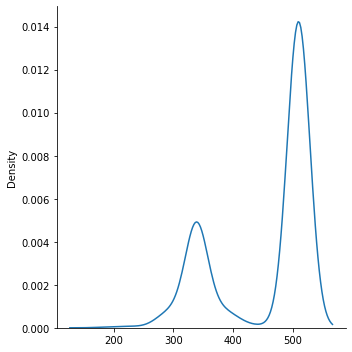

In [5]:
sns.displot(x=x_lr, kind="kde")


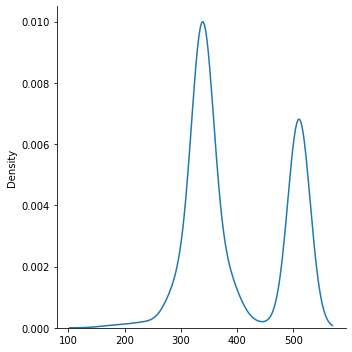

In [6]:
sns.displot(x=y_lr, kind="kde")


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

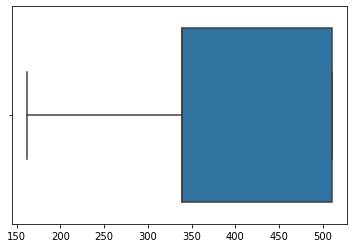

In [7]:
sns.boxplot(y_lr)

In [8]:
#Getting the percentile
for i in range(1,11):
    print('The',i*10,'% value for y codinate of the LR image is :',np.percentile(x_lr,i*10))

The 10 % value for y codinate of the LR image is : 339.0
The 20 % value for y codinate of the LR image is : 339.0
The 30 % value for y codinate of the LR image is : 384.0
The 40 % value for y codinate of the LR image is : 510.0
The 50 % value for y codinate of the LR image is : 510.0
The 60 % value for y codinate of the LR image is : 510.0
The 70 % value for y codinate of the LR image is : 510.0
The 80 % value for y codinate of the LR image is : 510.0
The 90 % value for y codinate of the LR image is : 510.0
The 100 % value for y codinate of the LR image is : 510.0


# Designing an experiment to calculate number of patches in order to reduce the overlap between randomly selected patches

In [9]:
# def calculate_points(patch_size,overlap_per,image_dimension):
    
#     '''
#     patch_size= size of the patch ie(50*50)
#     overlap_per= calculating the probability of overlap for that percentage
#     image_dimension= length and width of the image(here we have consider both of them same ie 510*510)
#     '''
#     #Randomly selecting an x,y coridnate for the upper left point of the patch in order to simulate random 
#     #behaviour
    
#     x_patch= np.random.randint(0,image_dimension-patch_size)
#     y_patch= np.random.randint(0,image_dimension-patch_size)    
    
#     #Here x will increase while y is fixed 
#     counter= 0 #It will calculater number of points which satisfied the condition
    
#     for y in range(0,image_dimension-patch_size):
        
#         for x in range(0,image_dimension-patch_size):
#             diff_x= abs(x_patch-x)
#             diff_y= abs(y_patch-y)

#             #For overlapping condition
#             if diff_x<patch_size and diff_y<patch_size:
                
#                 #when x coordinate of both patches are same
#                 if x_patch==x: 
#                     not_overlapping_area= diff_y*patch_size

#                 else:
#                     not_overlapping_area= diff_x*patch_size+diff_y*(patch_size-diff_x)

#                 overlapping_area_per= (not_overlapping_area/patch_size**2)*100

#                 if overlapping_area_per>= overlap_per:
#                     counter+=1
        
#     return counter
    
# def calculate_probability(patch_size,overlap_per,image_dimension,patches_num):
    
#     possible_points= [calculate_points(patch_size,overlap_per,image_dimension) for i in range(10)]
#     nu_of_points= sum(possible_points)//len(possible_points)
    
#     print('\nThe number of points giving overlap',overlap_per,'% is:',nu_of_points)
#     prob_single_point= 1/image_dimension*1/image_dimension
#     prob_nu_of_points= prob_single_point*nu_of_points
    
#     probability= 0
#     for i in range(1,patches_num):
#         probability= probability+prob_nu_of_points*i
    
#     print('\nThe probability for an single point',prob_single_point)
#     print('\nThe probability for an',nu_of_points, 'point',prob_nu_of_points)

#     print('\nThe percentage for ',overlap_per,'overlap is:',probability)
#     return 

In [10]:
def check(point_1,point_2):
    
    diff_x= abs(point_1[0]-point_2[0])
    diff_y= abs(point_1[1]-point_2[1])

    #For overlapping condition
    if diff_x<patch_size and diff_y<patch_size:

        #when x coordinate of both patches are same
        if point_1[0]==point_1[0]: 
            not_overlapping_area= diff_y*patch_size

        else:
            not_overlapping_area= diff_x*patch_size+diff_y*(patch_size-diff_x)

        overlapping_area_per= (not_overlapping_area/patch_size**2)*100

        if overlapping_area_per>= overlap_per:
            return True
        else:
            return False

        
def calculate_probability(patch_size,overlap_per,image_dimension,patches_num):
    patches_coordinate= []
    number_of_overlaps= 0
    for i in range(patches_num):
        x= np.random.randint(0,image_dimension-patch_size)
        y= np.random.randint(0,image_dimension-patch_size)    
        patches_coordinate.append((x,y))
    
    start= 0
    while start<patches_num-1:
        
        for i in range(start+1,patches_num):
            if check(patches_coordinate[start],patches_coordinate[i])==True:
                number_of_overlaps+=1
        
        start+=1
#     print('The number of overlaps:',number_of_overlaps)
    return number_of_overlaps

In [11]:
#Parameter for the patches
patch_size= 96 #For LR but for HR it will be 96
overlap_per= 80
image_dimension= 510
patches_upto= 50

<AxesSubplot:>

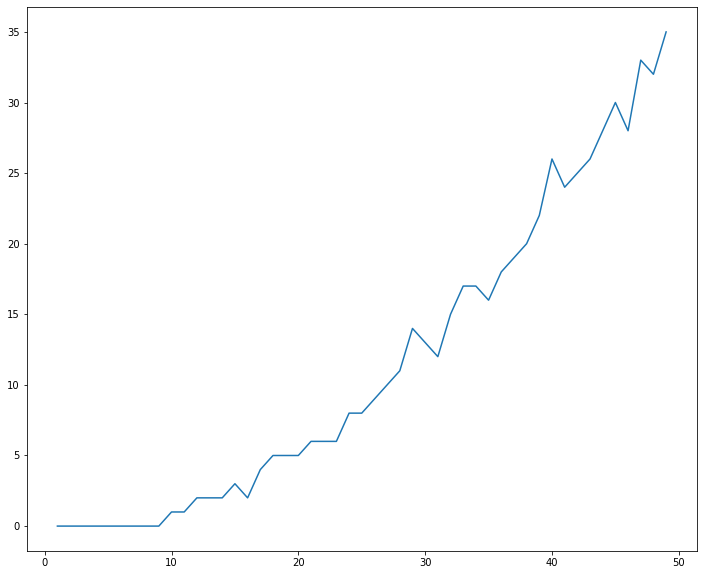

In [12]:
overlap_for_diff_patches_nu= []
for i in range(1,patches_upto):
    
    temp= [calculate_probability(patch_size,overlap_per,image_dimension,i) for j in range(20)]
    number_of_overlap= sum(temp)//len(temp)
    overlap_for_diff_patches_nu.append(number_of_overlap)

x= [i for i in range(1,patches_upto)]
plt.figure(figsize=[12,10])
sns.lineplot(x=x, y=overlap_for_diff_patches_nu,markers=True, dashes=False)

As we can see for 19 number of patches the overlap is 4, whereas for 20 patches the overlap is 5. There by taking 19 numbers of patches from an images we ensure that maximum information is extracted from the LR image while making the overlap as low as possible 

# Selecting the patches and creating an dataset of the patches

In [13]:
def selecting_a_patch(image_HR,image_LR,path,num,check):
    
    #Selecting the coordinate for the patch of LR
    x_lr= np.random.randint(0,image_LR.shape[0]-patch_size)
    y_lr= np.random.randint(0,image_LR.shape[1]-patch_size) 
    
#     print('The coordinate are:',(x_lr,y_lr))
    #Getting the coordinate for the patch of HR
    x_hr= x_lr*4 #Because our scaling is 4
    y_hr= y_lr*4 #Because our scaling is 4
    
    patch_lr= image_LR[x_lr:x_lr+patch_size,y_lr:y_lr+patch_size]
    patch_hr= image_HR[x_hr:x_hr+patch_size*4,y_hr:y_hr+patch_size*4]

    #Saving the patches
    image_number= path.split('/')[-1].split('.')[0]
    
    if check==True:    
        path_hr= './train/HR/'+image_number+'_p_'+str(num)+'.png'
        path_lr= './train/LR/'+image_number+'_p_'+str(num)+'.png'
    
    else:
        path_hr= './test/HR/'+image_number+'_p_'+str(num)+'.png'
        path_lr= './test/LR/'+image_number+'_p_'+str(num)+'.png'
    

    cv2.imwrite(path_hr, patch_hr)
  
    cv2.imwrite(path_lr, patch_lr)

    return 

def patching(path_to_hr,path_to_lr,train=True):
    for i in tqdm(range(len(path_to_hr))):
        image_hr= cv2.imread(path_to_hr[i])
        image_lr= cv2.imread(path_to_lr[i])

        for j in range(patches_num):
            selecting_a_patch(image_hr,image_lr,path_to_hr[i],j,train)
            
        
    

In [14]:
#Parameter
patches_num= 19

#For training
patching(train_paths_to_HR_images,train_paths_to_LR_images,True)
#For test
patching(test_paths_to_HR_images,test_paths_to_LR_images,train=False)


100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


In [15]:
# a= cv2.imread(train_paths_to_HR_images[0])
# b= cv2.imread(train_paths_to_LR_images[0])

# patch=selecting_a_patch(a,b,'salkjdf',1,True)
# print(cv2.imwrite('./test/HR/.png',patch))